## 6.3 배치 정규화(Batch Normalization)
배치 정규화 : 각 층의 활성화를 적당히 분포되도록 조정

##### 6.3.1 배치 정규화 알고리즘
__배치 정규화가 주목받는 이유__
- 1. 학습을 빨리 진행할 수 있다.
- 2. 초기값에 크게 의존하지 않는다.
- 3. Overfitting을 억제한다. (Dropout 등의 필요성 감소)

__배치 정규화 :__ 학습시 미니배치를 단위로 정규화<br><br>

배치 정규화의 기본 아이디어는 앞에서 말했듯이 각 층에서의 활성화값이 적당히 분포되도록 조정하는 것이다.<br><br>

__아래 그림과 같이 데이터 분포를 정규화하는 '배치 정규화 계층(Batch Norm)'을 신경망에 삽입한다.__
![](img/batch1.png)



![](img/batch2.png)

여기에는 미니배치 $B = \{x_1, x_2, ... x_m\}$ 이라는 $m$개의 입력 데이터의 집합에 대해 평균과 분산을 구한다. <br>그 후 <u>__데이터 분포가 평균이 0, 분산이 1이 되도록 정규화__</u><br>$\epsilon$ 값은 0으로 나누는 사태를 방지하는 역할

<br><br>
__방식은 매우 단순하며, Batch 처리를 활성화 함수의 앞(혹은 뒤)에 삽입함으로써 데이터 분포가 덜 치우치게 할 수 있다.__

<br><br>
또, 배치 정규화 계층마다 이 정규화된 데이터에 고유한 __확대(scale)__와 __이동(shift)__ 변환을 수행한다. <br>수식은 아래와 같다.
![](img/batch3.png)

> - 위 식에서 $\gamma$는 __확대__를, $\beta$는 __이동__을 담당한다. 
> - 두 값은 처음에는 1, 0부터 시작하고 학습하면서 적합한 값으로 조정해 간다.

전체적인 흐름은 아래와 같다. => 자세한 설명은 [프레드릭 크레저트(Frederik Kratzert)의 블로그](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
![](img/batch4.png)

##### 6.3.2 배치 정규화의 효과
MNIST 셋을 사용하여 배치 정규화 계층을 사용할 때와 사용하지 않을 때 학습 진도<br><br>
가중치 초기값의 표준편차를 다양하게 바꿔가며 학습 경과를 관찰한 그래프

##### Batch Normalization 사용 여부에 따른 비교

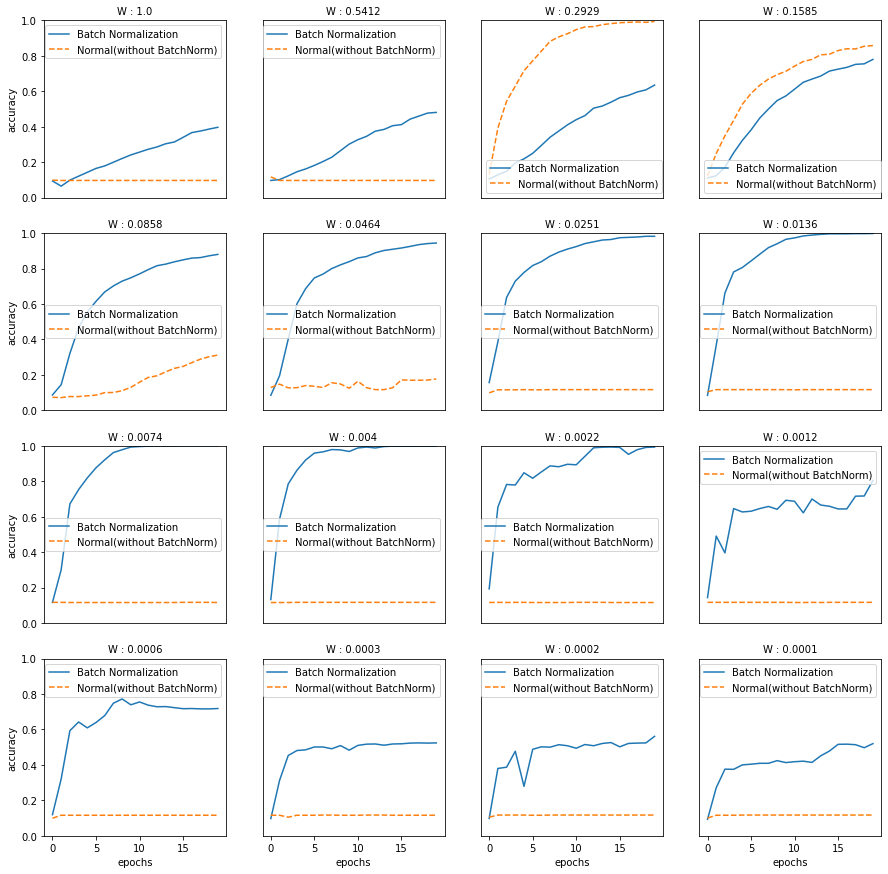

In [33]:
import warnings
warnings.filterwarnings(action='ignore')

# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/batch_norm_test.py 참고
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            #print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

fig = plt.figure(figsize=(15, 15)) 

for i, w in enumerate(weight_scale_list):
    #print( "============== " + str(i+1) + "/16 진행중 . . ." + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W : " + str(round(w, 4)), fontsize = 10)
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)
    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
        
    plt.legend(['Batch Normalization', 'Normal(without BatchNorm)'])    

    
    
plt.show()

> __거의 모든 경우에 Batch Normalization을 사용할 때 성능(Accuracy)가 높음을 확인__

---
## 6.4 바른 학습을 위해
__OverFitting__ : 신경망의 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에 제대로 대응하지 못하는 상태

##### 6.4.1 Overfitting
오버피팅이 발생하는 경우
- 매개변수가 많고 표현력이 높은 모델
- 훈련데이터가 적음

__아래에서는 일부러, 위 두 요건을 충족시켜 Overfitting발생__ <br><br>
훈련 데이터 중 300개만 사용 , 7층 Network를 사용해 네트워크 복잡성을 높임 <br><br>
각 층의 뉴런은 100개 활성화 함수는 ReLU를 사용

In [34]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/overfit_weight_decay.py 참고
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [39]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/overfit_weight_decay.py 참고
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]
import numpy as np
import matplotlib.pyplot as plt
from common.multi_layer_net import MultiLayerNet
#from common.optimizer import SGD

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        if epoch_cnt%20 == 0:
            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.12, test acc:0.1174
epoch:20, train acc:0.6766666666666666, test acc:0.4605
epoch:40, train acc:0.9, test acc:0.6397
epoch:60, train acc:0.9533333333333334, test acc:0.7088
epoch:80, train acc:0.9833333333333333, test acc:0.7303
epoch:100, train acc:0.9933333333333333, test acc:0.7472
epoch:120, train acc:0.9966666666666667, test acc:0.7503
epoch:140, train acc:1.0, test acc:0.7529
epoch:160, train acc:1.0, test acc:0.7605
epoch:180, train acc:1.0, test acc:0.7619
epoch:200, train acc:1.0, test acc:0.7619


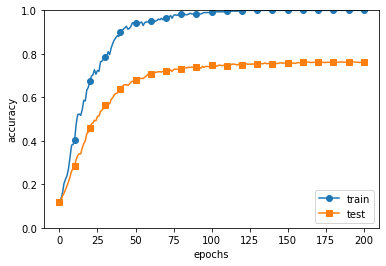

In [40]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

> - __train과 Test 데이터에 대한 Accuracy 차이가 엄청 큼__
> - 이것은 Overfitting이 발생했기 때문이다. 

##### 6.4.2 가중치 감소
- __학습과정에서 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 Overfitting을 억제하는 방법__
- 가중치를 $W$라 하면 __L2 법칙에 따른 가중치 감소__는 
$\frac{1}{2}\lambda W^2$가 되고, 이 값을 손실함수에 더함

<u>__L2 법칙__</u> <br>
$W = (W_1, W_2, ... W_n)$이 있다면
$\sqrt{{W_1}^2 + {W_2}^2 + ... + {W_n}^2}$

가중치 감소($\lambda = 0.1$)를 적용한 결과는 아래와 같다.

epoch:0, train acc:0.11333333333333333, test acc:0.1171
epoch:20, train acc:0.5666666666666667, test acc:0.4133
epoch:40, train acc:0.7566666666666667, test acc:0.6083
epoch:60, train acc:0.82, test acc:0.6525
epoch:80, train acc:0.8633333333333333, test acc:0.6859
epoch:100, train acc:0.8733333333333333, test acc:0.699
epoch:120, train acc:0.89, test acc:0.7022
epoch:140, train acc:0.8966666666666666, test acc:0.7213
epoch:160, train acc:0.9033333333333333, test acc:0.7196
epoch:180, train acc:0.8933333333333333, test acc:0.7311
epoch:200, train acc:0.89, test acc:0.7233


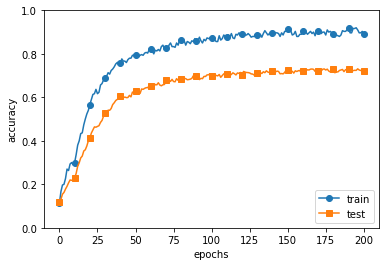

In [44]:
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        if epoch_cnt % 20 == 0:
            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1

        if epoch_cnt >= max_epochs:
            break
            
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

> - 훈련 데이터에 대한 정확도와 시험 데이터에 대한 정확도 차이가 줄어듬
> - 즉, __L2 법칙__을 사용함으로 인해, Overfitting이 억제됨

##### 6.4.3 드롭아웃(DropOut)

신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려움 <br><br>

__DropOut :__ 뉴런을 임의로 삭제하면서 학습하는 방법 <br><br>

훈련 때에는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택 <br><br>

__※ 시험 때에는 모든 뉴런에 신호를 전달 => 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하며 출력__

##### Dropout 구현

In [45]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

> - 훈련 시에는 순전파 때마다 __self.mask__에 삭제할 뉴런을 False로 표시
> - 역전파 때의 동작은 __ReLU__와 같음
> - __순전파 때 통과시키지 않은 뉴런은 역전파 때도 신호를 차단.__

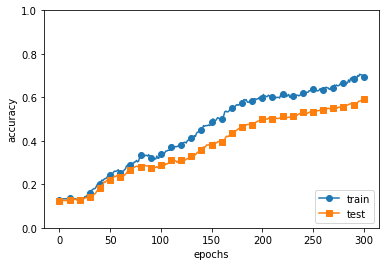

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

드롭아웃을 적용하니 Train, Test에 대한 정확도 차이가 줄었다.<br><br>

드롭아웃을 이용하면 표현력을 높이면서 Overfitting 억제 가능 <br><br>

__Ensemble Learning(앙상블 학습)__
- 같은 구조의 네트워크를 여러 개 준비하여 따로따로 학습
- 여러 개의 출력을 평균내어 답변
- Dropout은 Ensemble Learning과 같은 효과를 (대략) 하나의 네트워크로 구현했다고 볼 수 있다.

---
## 6.5 적절한 하이퍼 파라미터 값 찾기

각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률, 가중치 감소 등 <br><br>
Hyper Parameter 값을 최대한 효율적으로 탐색하는 방법

##### 6.5.1 검증 데이터